<a href="https://colab.research.google.com/github/moshemontesinos/guarantee_calculator_notebook/blob/main/BH_interactive_guarantee_calc_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd

from bokeh.layouts import gridplot
from bokeh.models import CustomJS, Slider, ColumnDataSource, WidgetBox, HoverTool
from bokeh.plotting import figure, output_file, show

# Setup bokeh for Jupyter
from bokeh.io import output_notebook
output_notebook()

In [ ]:
## PRELIMINARY DATA PREPARATION STEPS
# Base case df [upload data]
df = pd.read_csv("https://raw.githubusercontent.com/moshemontesinos/BH_mit_p3_calculator/master/BH_data_hyp_case_v2.csv")
df['net_cfs'] = df['revs'] - df['capital'] - df['o_m']
df.head()

,time,revs,capital,o_m,net_cfs
0,0,0,0,0,0
1,1,0,120000000,0,-120000000
2,2,0,120000000,0,-120000000
3,3,0,120000000,0,-120000000
4,4,0,120000000,0,-120000000


In [ ]:
## PART A ##
# INPUTS TO CALCULATE CAPM (ra)
rf = 0.02
Beta = 0.805
premium = 0.06
inflation = 0.021
ra = rf + Beta*premium - inflation
ra = round(ra,3)
vol = 0.30
strike = 15000000

In [ ]:
## PART B ##

# Calculate forward value per row, under following assumptions:
# before year no. 13 --> revs*exp(rf*time)/(1+ra)^time
# from year no. 13 on --> revs[12]*exp(rf*time)/(1+ra)^time)

# Executing arithmetic directly on slices of the DataFrame
t = 11
df.loc[0:t,'fw'] = df.loc[0:t,'revs']*np.exp(rf*df.loc[0:t,'time']) / \
                   (1+ra)**df.loc[0:t,'time']
df.loc[t+1:,'fw'] = df.loc[t+1,'revs']*np.exp(rf*df.loc[t+1:,'time']) / \
                    (1+ra)**df.loc[t+1:,'time']

# If we didn't have different formulas for fw based on t, or if we set 
#   df.loc[t+1:,'revs'] = df.loc[t+1,'revs']
# we could calculate fw more compactly using pd.apply and a named function
# applied to each row of the DataFrame:
#   def calc_fw(rev, t, rf, ra):
#     return rev*np.exp(rf*t)/(1+ra)**t
#   df['fw'] = df.apply(lambda x: calc_fw(x['revs'], x['time'], rf, ra), axis=1)

# Yet another way (my preference), using an anonymous function:
#   df['fw'] = df.apply(
#               lambda x: 
#                 x['revs']*np.exp(rf*x['time'])/(1+ra)**x['time'], axis=1
#              )

# Calculate put value as a function of time
df['d1'] = (np.log(df['fw']/strike) + df['time']*(vol**2)/2) / \
           (vol*np.sqrt(df['time']))
df['d1'] = df['d1'].replace(np.NINF, np.NAN)
df['d2'] = df['d1'] - (vol*np.sqrt(df['time']))
df['N_d1'] = norm.cdf(-df['d1'])
df['N_d2'] = norm.cdf(-df['d2'])
df['put'] = np.exp(-rf*df['time'])*(strike*df['N_d2'] - df['fw']*df['N_d1'])

df.head(20)
df.to_csv('data.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


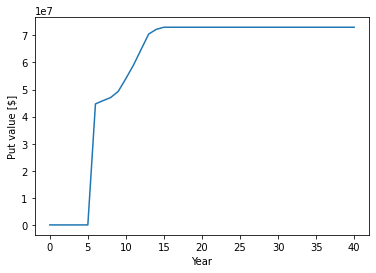

In [ ]:
plt.plot(df['time'], df['revs'])
plt.xlabel('Year');
plt.ylabel('Put value [$]');



In [ ]:
# Verify that this worksheet's calculations match the original R script
df2 = pd.read_csv('original_results.csv')
df2.columns = df.columns
(df2-df).abs().max()

FileNotFoundError: ignored

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


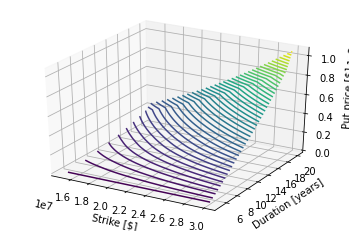

In [ ]:
def put_prices(strike):
  df['d1'] = (np.log(df['fw']/strike) + df['time']*(vol**2)/2) / (vol*np.sqrt(df['time']))
  df['d1'] = df['d1'].replace(np.NINF, np.NAN)
  df['d2'] = df['d1'] - (vol*np.sqrt(df['time']))
  df['N_d1'] = norm.cdf(-df['d1'])
  df['N_d2'] = norm.cdf(-df['d2'])
  df['put'] = np.exp(-rf*df['time'])*(strike*df['N_d2'] - df['fw']*df['N_d1'])
  return df['put']

def put_sum(strike, duration):
  df['d1'] = (np.log(df['fw']/strike) + df['time']*(vol**2)/2) / (vol*np.sqrt(df['time']))
  df['d1'] = df['d1'].replace(np.NINF, np.NAN)
  df['d2'] = df['d1'] - (vol*np.sqrt(df['time']))
  df['N_d1'] = norm.cdf(-df['d1'])
  df['N_d2'] = norm.cdf(-df['d2'])
  df['put'] = np.exp(-rf*df['time'])*(strike*df['N_d2'] - df['fw']*df['N_d1'])
  return df.loc[0:duration, 'put'].sum()

strike = np.linspace(15e6, 30e6, 30)
duration = np.linspace(5, 20, 15)

X, Y = np.meshgrid(strike, duration)
Z = np.vectorize(put_sum)(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('Strike [$]')
ax.set_ylabel('Duration [years]')
ax.set_zlabel('Put price [$]');

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


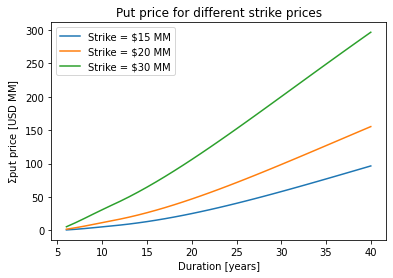

In [ ]:
fig = plt.figure()
strikes = [15e6, 20e6, 30e6]
duration = np.linspace(5,20,15)
for strike in strikes:
    plt.plot(np.cumsum(put_prices(strike))/1e6)
  
plt.legend(['Strike = $' + str(int(s/1e6)) + ' MM' for s in strikes])
plt.xlabel('Duration [years]')
plt.ylabel('$\Sigma$put price [USD MM]')
plt.title('Put price for different strike prices');

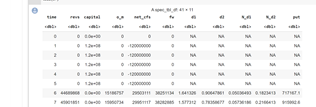

### **Reference Formula:** 
(Black's model for commodity put option)

$$p_{0,t} = e^{-ρ_t T} [XN(-d_2) - F_tN(-d1)]$$
where:
$$d_1 = \frac{ln(F_t/X) + σ_t^2\text{ }/\text{ } T}{σ_t\sqrt{T}} \text{   , and}\text{  } d_2 = d_1 - σ_t$$


In [ ]:
# INPUTS
# formula above will be calculated for each row in dataframe (For loop?), starting from 1st year of construction (in this case: year 6) 
                    # time  = time to maturity
                    # fw = forward price of the revenue flow at T
                    # strike  = minimum guaranteed revenue (X in the formula)
                    # rf = risk-free rate (ALREADY MENTIONED CELL ABOVE IN CAPM)
                    # vol1 = volatility of revenues (Constant version)
                    # vol2 = volatility of revenues (Changing version)
                    # N_d1 =  cumulative normal distribution


# The total value of the "Government support" is just the CUMULATIVE sum of the put options for each year 
                    # duration = c(5,10, 20)


## PART A ##
# Constants
rf = 0.02
Beta = 0.805
premium = 0.06
inflation = 0.021
ra = rf + Beta*premium - inflation
ra = round(ra,3)
vol0 = 0.3

t = np.arange(0,41,1)
vol = np.ones((41,))*vol0
df = pd.read_csv("https://raw.githubusercontent.com/moshemontesinos/BH_mit_p3_calculator/master/BH_data_hyp_case_v2.csv")
revenue = df['revs'].to_numpy()
revenue[12:] = revenue[12]
strike = np.array([15e6, 20e6, 30e6])

def FW(revenue, t, rf, ra):
  return revenue*np.exp(rf*t)/(1+ra)**t

def D1(fw, t, vol, strike):
  return (np.log(fw/strike) + t*(vol**2)/2) / (vol*np.sqrt(t))

def D2(d1, t, vol):
  return d1 - vol*np.sqrt(t)

def N_d1(d1):
  return norm.cdf(-d1)

def N_d2(d2):
  return norm.cdf(-D2(fw, t, vol, strike))

def put(revenue, rf, ra, t, vol, strike):
  fw = FW(revenue, t, rf, ra)
  d1 = D1(fw, t, vol, strike)
  d2 = D2(d1, t, vol)
  return np.exp(-rf*t)*(strike*norm.cdf(-d2) - fw*norm.cdf(-d1))


#df['d1'] = (np.log(df['fw']/strike) + df['time']*(vol**2)/2) / (vol*np.sqrt(df['time']))
#  df['d1'] = df['d1'].replace(np.NINF, np.NAN)
#  df['d2'] = df['d1'] - (vol*np.sqrt(df['time']))
#  df['N_d1'] = norm.cdf(-df['d1'])
#  df['N_d2'] = norm.cdf(-df['d2'])
#  df['put'] = np.exp(-rf*df['time'])*(strike*df['N_d2'] - df['fw']*df['N_d1'])

put_prices = put(revenue, rf, ra, t, vol, strikes[0])
total_put_price = put_prices.cumsum()/1e6

# Figure setup
fig = figure(tools='', x_range=(0, max(t)), y_range=(0, max(total_put_price)))

fig.toolbar.logo = None
fig.toolbar_location = None

fig.xaxis.axis_label = "Duration [years]"
fig.yaxis.axis_label = "Put Option Price [MM USD]"

fig.xaxis.minor_tick_line_color = None
fig.yaxis.minor_tick_line_color = None
fig.min_border_right = 20

fig.plot_height = 400
fig.width = 500

# Drawing the primary line
source = ColumnDataSource(data=dict(x=t, y=total_put_price))
line = fig.line(x='x', y='y', source=source, line_width=6, color='DarkTurquoise')

# Adding hover-ability to the line and setting the tooltip format
fig.add_tools(HoverTool(renderers=[line], tooltips="(@x{(0,0)}, $@y{(0,0.00)})"))

t0 = 15
source2 = ColumnDataSource(data=dict(x2=[t[t0]], y2=[total_put_price[t0]]))
# Drawing the limit
fig.circle_cross(x='x2', y='y2', source=source2, size=10, line_width=2)

# -----------------------------------------------------------------------------

# Calculate the call option price and let it be updated by the sliders

value = 'Put Option Price = ${0:.2f} MM'.format(total_put_price[t0])
source3 = ColumnDataSource(data=dict(text=[value]))

# Create a container for the bond price to be displayed within
text_box = figure(x_range=(-8, 8), y_range=(-4, 4),
                  plot_width=500, plot_height=40, tools='')
text_box.axis.visible = False
text_box.outline_line_color = None
text_box.rect(0, 0, width=18, height=10, fill_color='white', line_color='white')

# Adds the text to the container
text_box.text(0, 0, text='text', text_font_size='12pt', text_baseline='middle',
              text_align='center', source=source3)

grid = gridplot([[text_box], [fig]], toolbar_options=dict(logo=None))
show(grid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


1500000.0

In [ ]:
S = 500
K = 500
r = 0.02
tau = 1
sig = 0.2 


# Calculating x and y data for the pre-slider drawing of the primary line
x = np.arange(0, 1000.01, 0.01)
a1 = np.log(x / (K * np.exp(-r * tau))) / (sig * np.sqrt(tau)) + sig * np.sqrt(tau) / 2
a2 = a1 - sig * np.sqrt(tau)
y = x * norm.cdf(a1) - K * np.exp(-r * tau) * norm.cdf(a2)

source = ColumnDataSource(data=dict(x=x, y=y))

# -----------------------------------------------------------------------------

# Creating the container of the plot and setting its properties
fig = figure(tools='', x_range=(0, 1000), y_range=(0, 1000))

fig.toolbar.logo = None
fig.toolbar_location = None

fig.xaxis.axis_label = "Share Price ($)"
fig.yaxis.axis_label = "Call Option Price ($)"

fig.xaxis.minor_tick_line_color = None
fig.yaxis.minor_tick_line_color = None
fig.min_border_right = 20

fig.plot_height = 400
fig.width = 500

# Drawing the primary line
line = fig.line(x='x', y='y', source=source, line_width=6, color='DarkTurquoise')

# Adding hover-ability to the line and setting the tooltip format
fig.add_tools(HoverTool(renderers=[line], tooltips="($@x{(0,0.00)}, $@y{(0,0.00)})"))

# -----------------------------------------------------------------------------

# Calculating x and y data for the pre-slider drawing of the zero line
x2 = np.arange(500, 500 + 0.01, 0.01)
a1 = np.log(x2 / (K * np.exp(-r * tau))) / (sig * np.sqrt(tau)) + sig * np.sqrt(tau) / 2
a2 = a1 - sig * np.sqrt(tau)
y2 = x2 * norm.cdf(a1) - K * np.exp(-r * tau) * norm.cdf(a2)

source2 = ColumnDataSource(data=dict(x2=x2, y2=y2))

# Drawing the limit

fig.circle_cross(x='x2', y='y2', source=source2, size=10, line_width=2)

# -----------------------------------------------------------------------------

# Calculate the call option price and let it be updated by the sliders
value = 'Call Option Price = ${0:.2f}'.format(y2[0])
source3 = ColumnDataSource(data=dict(text=[value]))

# Create a container for the bond price to be displayed within
text_box = figure(x_range=(-8, 8), y_range=(-4, 4),
                  plot_width=500, plot_height=40, tools='')
text_box.axis.visible = False
text_box.outline_line_color = None
text_box.rect(0, 0, width=18, height=10, fill_color='white', line_color='white')

# Adds the text to the container
text_box.text(0, 0, text='text', text_font_size='12pt', text_baseline='middle',
              text_align='center', source=source3)

grid = gridplot([[text_box], [fig]], toolbar_options=dict(logo=None))
show(grid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
import numpy as np

from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, CustomJS, Slider, HoverTool
from bokeh.plotting import output_notebook, figure, show

output_notebook()

# Initial graph is "hard coded"
x = np.arange(0, 40, 1)
y = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.72, 1.66, 2.76, 3.99, 5.3, 
              6.65, 8.02, 9.39, 10.94, 12.67, 14.58, 16.65, 18.87, 21.25, 23.78, 
              26.43, 29.22, 32.12, 35.13, 38.24, 41.45, 44.74, 48.11, 51.55, 
              55.05, 58.62, 62.23, 65.88, 69.58, 73.3, 77.06, 80.84, 84.63, 88.44])

source = ColumnDataSource(data=dict(x=x, y=y))

fig = figure(y_range=(0, 200), width=600, height=400)

line = fig.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

# Adding hover-ability to the line and setting the tooltip format
fig.add_tools(HoverTool(renderers=[line], tooltips="($@x{(0,0.00)}, $@y{(0,0.00)})"))

fig.toolbar.logo = None
fig.toolbar_location = None

fig.xaxis.axis_label = "Duration (years)"
fig.yaxis.axis_label = "Minimum revenue guarantee (Millions of USD)"

fig.xaxis.minor_tick_line_color = None
fig.yaxis.minor_tick_line_color = None
fig.min_border_right = 20


duration_slider =     Slider(start=20, end=100, value=40, step=1, 
                             title="Project duration (years)")
construction_slider = Slider(start=1, end=19, value=5, step=1, 
                             title="Construction duration (years)")
vol_slider =          Slider(start=0.0, end=1, value=0.3, step=.01, 
                             title="Volatility")
strike_slider =       Slider(start=0, end=50, value=15, step=1, 
                             title="Strike price (millions of USD)")
rf_slider =           Slider(start=0, end=0.1, value=0.02, step=.01, 
                             title="Rf")
beta_slider =         Slider(start=0, end=1, value=0.805, step=.05, 
                             title="Beta")
mkt_premium_slider =  Slider(start=0, end=0.2, value=0.06, step=.01, 
                             title="Market premium")
inflation_slider =    Slider(start=0, end=0.2, value=0.021, step=.01, 
                             title="Inflation")

callback = CustomJS(args=dict(source1=source1,
                              source2=source2,
                              Duration=duration_slider,
                              Construction=construction_slider,
                              Vol=vol_slider,
                              Strike=strike_slider,
                              Rf=rf_slider,
                              Beta=beta_slider,
                              Mkt_premium=mkt_premium_slider,
                              Inflation=inflation_slider,
                              ),
                    code="""
    const data = source.data;
    const duration = Duration.value;
    const construction = Construction.value;
    const operation = duration - construction; 
    const vol = Vol.value;
    const strike = Strike.value*1e6;
    const rf = Rf.value;
    const beta = Beta.value;
    const mkt_premium = Mkt_premium.value;
    const inflation = Inflation.value;

    const ra = rf + beta*mkt_premium - inflation;

    const x = data['x']
    const y = data['y']

    function cdf(x) {
        return 0.5 * (1 + erf(x / Math.sqrt(2)));
    }

    function erf(x) {
        // save the sign of x
        var sign = (x >= 0) ? 1 : -1;
        x = Math.abs(x);

        // constants
        var a1 =  0.254829592;
        var a2 = -0.284496736;
        var a3 =  1.421413741;
        var a4 = -1.453152027;
        var a5 =  1.061405429;
        var p  =  0.3275911;

        // A&S formula 7.1.26
        var t = 1.0/(1.0 + p*x);
        var y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * Math.exp(-x * x);
        return sign * y; // erf(-x) = -erf(x);
    }

    // This function approximates the given revenue data. It should be replaced by a model
    // which depends on the project's construction duration and operation parameters.
    function rev(t) {
      if (t <= 5) {
        return 0;
      } else if (t <= 13) {
        return 487136.83*t*t - 5495455.19*t + 60104914.23; 
      }
        else {
        return 487136.83*13*13 - 5495455.19*13 + 60104914.23; 
      }
    }

    function fw(t) {
        return rev(t)*Math.exp(rf*t)/Math.pow((1+ra), t);
    }

    function d1(t) {
      return (Math.log(fw(t)/strike) + t*vol*vol/2) / (vol*Math.sqrt(t));
    }

    function d2(t) {
      return d1(t) - vol*Math.sqrt(t);
    }

    function N_d1(t) {
        return cdf(-d1(t));
    }

    function N_d2(t) {
        return cdf(-d2(t));
    }

    function put(t) {
        // This assumes that rev(t) is also a function of the construction duration. 
        if ( t<=construction ) {
          return 0;
        } else {
          return Math.exp(-rf*t) * (strike*N_d2(t) - fw(t)*N_d1(t));
        }
    }


    for (let i = 0; i <  x.length; i++) {
        // Plot the cumulative sum of yearly put prices
        if (i === 0) {
          y[i] = put(x[i])/1e6;
        } else {
          y[i] = y[i-1] + put(x[i])/1e6;
        }
    }

    source.change.emit();
""")

duration_slider.js_on_change('value', callback)
construction_slider.js_on_change('value', callback)
vol_slider.js_on_change('value', callback)
strike_slider.js_on_change('value', callback)
rf_slider.js_on_change('value', callback)
beta_slider.js_on_change('value', callback)
mkt_premium_slider.js_on_change('value', callback)
inflation_slider.js_on_change('value', callback)

layout = row(
    fig,
    column(duration_slider, 
           construction_slider, 
           vol_slider, strike_slider, 
           rf_slider, 
           beta_slider, 
           mkt_premium_slider, 
           inflation_slider)
)

show(layout)

In [ ]:
from bokeh.resources import CDN
from bokeh.embed import file_html

html = file_html(layout, CDN, "my plot")
with open('output.html', 'w') as f:
  f.write(html)